In [1]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download -d andrewmvd/sp-500-stocks
!unzip sp-500-stocks.zip

#https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_stocks.csv

-rw-r--r-- 1 root root 64 Apr 29 11:59 kaggle.json
/content
 77% 33.0M/42.6M [00:00<00:00, 77.4MB/s]
100% 42.6M/42.6M [00:00<00:00, 80.0MB/s]
Archive:  sp-500-stocks.zip
  inflating: sp500_companies.csv     
  inflating: sp500_index.csv         
  inflating: sp500_stocks.csv        


In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
class Index:
  def __init__(self):
    self.data = {}

  def add_data(self, date, price):
    self.data[date] = price

  def get_price(self, date):
    return self.data.get(date)

  def get_previous_trading_day(self, date):
    current_date = datetime.strptime(date, "%Y-%m-%d")
    for _ in range(5):
      current_date -= timedelta(days=1)
      previous_date = current_date.strftime("%Y-%m-%d")
      if previous_date in self.data:
        return previous_date
    return None

  def calculate_price_change(self, date):
    price_today = self.get_price(date)
    previous_date = self.get_previous_trading_day(date)
    if price_today is not None and previous_date is not None:
      price_yesterday = self.get_price(previous_date)
      price_change = round(price_today - price_yesterday, 2)
      if price_yesterday != 0:
        percentage_change = round((price_change / price_yesterday) * 100, 2)
      else:
        percentage_change = 0
      return price_change, percentage_change
    return None, None

  def calculate_price_movement(self, date):
    price_change = self.calculate_price_change(date)[0]
    if price_change>0:
      return "Up"
    elif price_change<0:
      return "Down"
    else:
      return "Unchanged"

In [4]:
sp500 = Index()

with open("sp500_index.csv", "r") as index_file:
    index_reader = csv.reader(index_file)
    next(index_reader)
    for date, price in index_reader:
        sp500.add_data(date, float(price))

In [5]:
class Company:
  def __init__(self, exchange, symbol, shortname, longname, sector, industry, currentprice, marketcap, ebitda, revenuegrowth, city, state, country, fulltimeemployees, longbusinesssummary, weight):
        self.exchange = exchange
        self.symbol = symbol
        self.shortname = shortname
        self.longname = longname
        self.sector = sector if sector else 'Unknown'
        self.industry = industry if industry else 'Unknown'
        self.currentprice = float(currentprice)
        self.marketcap = int(marketcap)
        self.ebitda = int(ebitda) if ebitda else 0
        self.revenuegrowth = float(revenuegrowth) if revenuegrowth else 0
        self.city = city
        self.state = state if state else 'Not applicable'
        self.country = country
        self.fulltimeemployees = int(fulltimeemployees) if fulltimeemployees else 0
        self.longbusinesssummary = longbusinesssummary
        self.weight = float(weight)
        self.stock_data = {}

        self.pe_ratio = self.calculate_pe_ratio()
        self.ps_ratio = self.calculate_ps_ratio()
        self.pb_ratio = self.calculate_pb_ratio()
        self.roe = self.calculate_roe()
        self.ev = self.calculate_ev()
        self.ev_ebitda_ratio = self.calculate_ev_ebitda_ratio()

  def add_stock(self, date, adj_close, close, high, low, open, volume):
    date_key = date
    if date_key not in self.stock_data:
        self.stock_data[date_key] = {
            'adj_close': adj_close,
            'close': close,
            'high': high,
            'low': low,
            'open': open,
            'volume': volume
        }
  def __repr__(self):
        return f"Company(Symbol='{self.symbol}', Shortname='{self.shortname}', Sector='{self.sector}', Industry='{self.industry}', Currentprice={self.currentprice}, Marketcap={self.marketcap}, Ebitda={self.ebitda}, Revenuegrowth={self.revenuegrowth}, City='{self.city}', State='{self.state}', Country='{self.country}', Fulltimeemployees={self.fulltimeemployees}, Longbusinesssummary='{self.longbusinesssummary}', Weight={self.weight})"

  def __getitem__(self, date):
    if date in self.stock_data:
        return self.stock_data[date]
    else:
        return "No stock data available for the specified date."

    def get_previous_trading_day(self, date):
      current_date = datetime.strptime(date, "%Y-%m-%d")
      for _ in range(5):
        current_date -= timedelta(days=1)
        previous_date = current_date.strftime("%Y-%m-%d")
        if previous_date in self.stock_data:
          return previous_date
      return None

  def calculate_pe_ratio(self): #Price-to-Earnings (P/E) ratio indicates how much investors are willing to pay per dollar of earnings.
        if self.ebitda != 0:
            return self.currentprice / self.ebitda
        else:
            return None

  def calculate_ps_ratio(self): #Price-to-Sales (P/S) ratio indicates how much investors are willing to pay per dollar of sales.
        if self.revenuegrowth != 0:
            return self.marketcap / self.revenuegrowth
        else:
            return None

  def calculate_pb_ratio(self): #Price-to-Book (P/B) ratio represents the difference between a company's total assets and liabilities
        if self.fulltimeemployees != 0:
            return self.marketcap / self.fulltimeemployees
        else:
            return None

  def calculate_roe(self): #Return on Equity (ROE) ratio evaluates the efficiency of making profit while using the owned equity.
        if self.marketcap != 0:
            return self.revenuegrowth / self.marketcap
        else:
            return None

  def calculate_ev(self): #Enterprise Value (EV) - the total value of a company
        return self.marketcap + self.ebitda

  def calculate_ev_ebitda_ratio(self): # EV/EBITDA - measures company's valuation relative to its earnings.
        if self.ebitda != 0:
            return self.ev / self.ebitda
        else:
            return None

  def get_stock_data_for_date_range(self, start_date, end_date):
        data_in_range = {}
        for date, stock_data in self.stock_data.items():
            if start_date <= date <= end_date:
                data_in_range[date] = stock_data
        return data_in_range

  def price_change(self, date):
      if date in self.stock_data:
          price_change = self.stock_data[date]['close'] - self.stock_data[date]['open']
          percentage_change = (price_change / self.stock_data[date]['open']) * 100
          return price_change, percentage_change
      return None, None

  def price_movement(self, date):
      price_change, _ = self.price_change(date)
      if price_change is not None:
        if price_change > 0:
          return "Up"
        elif price_change < 0:
          return "Down"
        else:
          return "Unchanged"
      else:
        return "No data available"

  def ML_guess_stock_next_day(self, date):
        if date in self.stock_data:
            features = []
            target = []
            data = self.get_stock_data_for_date_range('2010-01-04', date)

            for date_key, stock_data in data.items():
                if date_key != date:
                    pe_ratio = self.calculate_pe_ratio()
                    ps_ratio = self.calculate_ps_ratio()
                    pb_ratio = self.calculate_pb_ratio()
                    roe_ratio = self.calculate_roe()
                    ev_ebitda_ratio = self.calculate_ev_ebitda_ratio()

                    features.append([
                        stock_data['high'],
                        stock_data['low'],
                        stock_data['open'],
                        stock_data['volume'],
                        pe_ratio,
                        ps_ratio,
                        pb_ratio,
                        roe_ratio,
                        ev_ebitda_ratio
                    ])
                    target.append(self.stock_data[date_key]['close'])

            X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

            # Create and train Gradient Boosting Regressor model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predict next day's stock price
            predicted_price = model.predict([[
                self.stock_data[date]['high'],
                self.stock_data[date]['low'],
                self.stock_data[date]['open'],
                self.stock_data[date]['volume'],
                pe_ratio,
                ps_ratio,
                pb_ratio,
                roe_ratio,
                ev_ebitda_ratio
            ]])

            return predicted_price[0]

        return None

In [6]:
companies = []

with open("sp500_companies.csv", "r") as companies_file:
    companies_reader = csv.reader(companies_file)
    next(companies_reader)
    for data in companies_reader:
        exchange, symbol, shortname, longname, sector, industry, currentprice, marketcap, ebitda, revenuegrowth, city, state, country, fulltimeemployees, longbusinesssummary, weight = data

        company = Company(exchange, symbol, shortname, longname, sector, industry, currentprice, marketcap, ebitda, revenuegrowth, city, state, country, fulltimeemployees, longbusinesssummary, weight)
        companies.append(company)

In [7]:
with open("sp500_stocks.csv", "r") as stocks_file:
  stocks_reader = csv.reader(stocks_file)
  next(stocks_reader)
  for line in stocks_reader:
    date, symbol, adj_close, close, high, low, open, volume = line
    if adj_close and close and high and low and open and volume:
      adj_close = round(float(adj_close), 2)
      close = round(float(close), 2)
      high = round(float(high), 2)
      low = round(float(low), 2)
      open = round(float(open), 2)
      volume = round(float(volume), 2)
      for company in companies:
        if company.symbol == symbol:
          company.add_stock(date, adj_close, close, high, low, open, volume)
          break

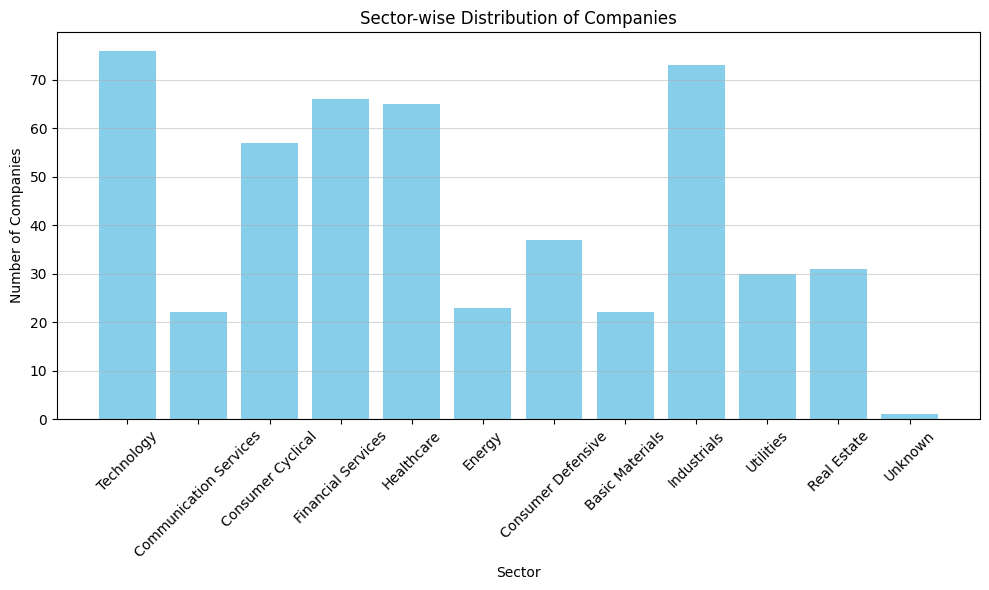

In [ ]:
def plot_sector_distribution(companies):
    sector_counts = {}
    for company in companies:
        sector = company.sector
        sector_counts[sector] = sector_counts.get(sector, 0) + 1

    sectors = list(sector_counts.keys())
    counts = list(sector_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(sectors, counts, color='skyblue')
    plt.title("Sector-wise Distribution of Companies")
    plt.xlabel("Sector")
    plt.ylabel("Number of Companies")
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_sector_distribution(companies)

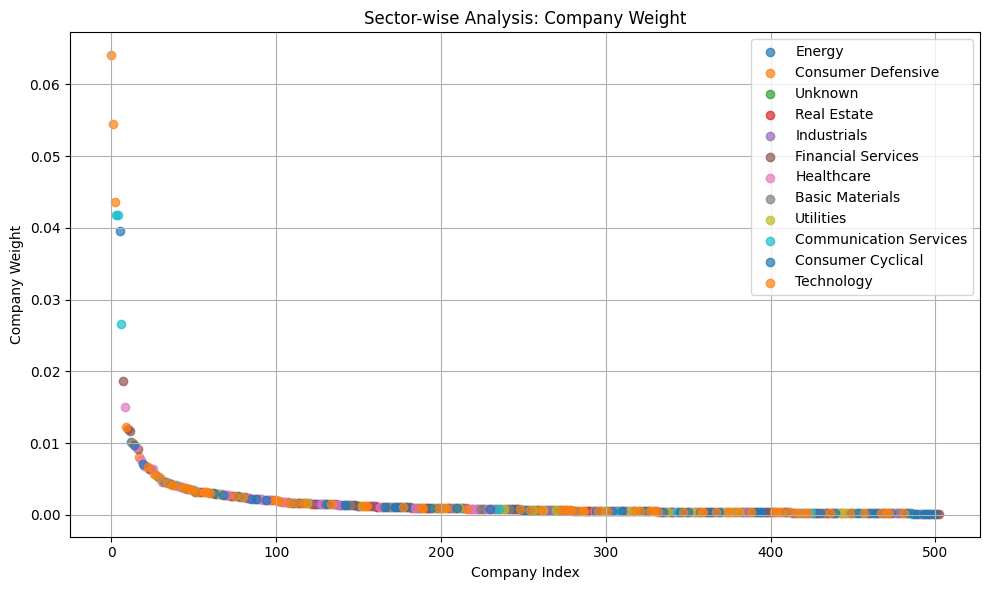

In [ ]:
def sector_weight_graph(companies):
  sectors = set(company.sector for company in companies)
  full_index = list(range(len(companies)))

  plt.figure(figsize=(10, 6))
  for sector in sectors:
      sector_companies = [company for company in companies if company.sector == sector]

      weights = [company.weight for company in sector_companies]
      company_indices = [full_index[companies.index(company)] for company in sector_companies]

      plt.scatter(company_indices, weights, label=sector, alpha=0.7)

  plt.title("Sector-wise Analysis: Company Weight")
  plt.xlabel("Company Index")
  plt.ylabel("Company Weight")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

sector_weight_graph(companies)

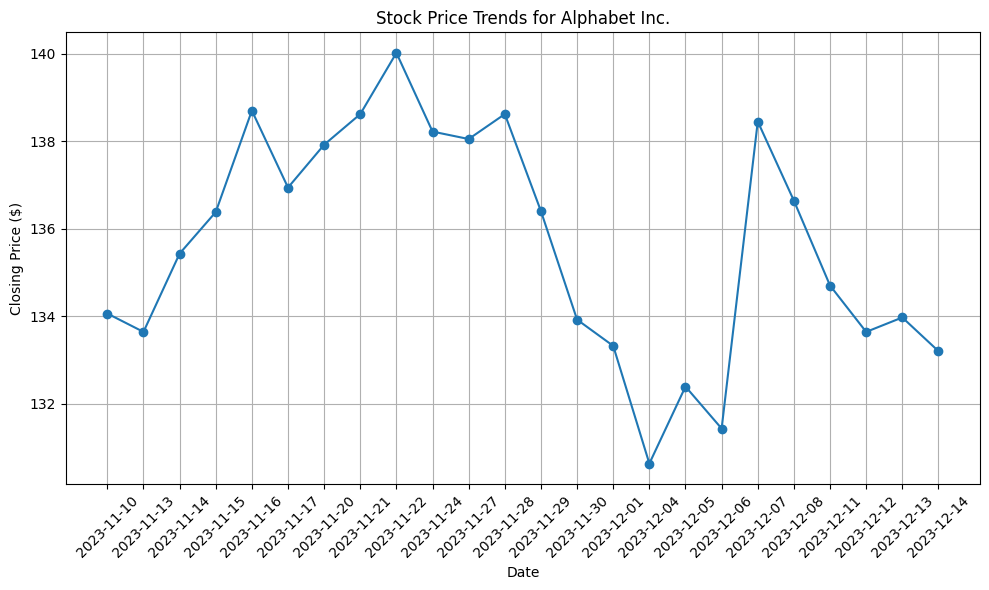

In [ ]:
def plot_stock_price_graph(companies, symbol, start_date, end_date):

    company = next((c for c in companies if c.symbol == symbol), None)
    if company is None:
        print(f"Company with symbol '{symbol}' not found.")
        return

    stock_data = company.get_stock_data_for_date_range(start_date, end_date)
    dates = list(stock_data.keys())
    close_prices = [data['close'] for data in stock_data.values()]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, close_prices, marker='o', linestyle='-')
    plt.title(f"Stock Price Trends for {company.shortname}")
    plt.xlabel("Date")
    plt.ylabel("Closing Price ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_stock_price_graph(companies, 'GOOG', '2023-11-10', '2023-12-14')

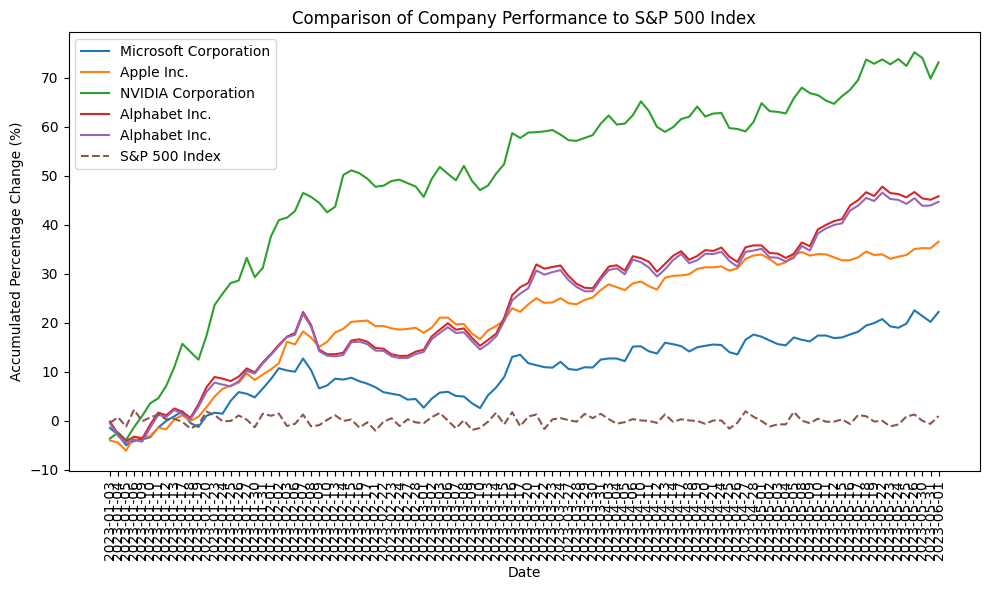

In [ ]:
def visualize_performance(companies_range, index, start_date, end_date):
    dates = []
    index_performance = []

    for date in index.data.keys():
        if start_date <= date <= end_date:
            dates.append(date)
            index_change = index.calculate_price_change(date)[1]
            index_performance.append(index_change if index_change is not None else 0)

    plt.figure(figsize=(10, 6))

    for company in companies_range:
        accumulated_performance = 0
        company_performance = []

        for date in dates:
            _, percentage_change = company.price_change(date)
            if percentage_change is not None:
                accumulated_performance += percentage_change
                company_performance.append(accumulated_performance)
            else:
                company_performance.append(0)

        plt.plot(dates, company_performance, label=company.shortname)

    plt.plot(dates, index_performance, label="S&P 500 Index", linestyle='--')

    plt.xlabel("Date")
    plt.ylabel("Accumulated Percentage Change (%)")
    plt.title("Comparison of Company Performance to S&P 500 Index")
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

visualize_performance(companies[0:5], sp500, "2023-01-01", "2023-06-01")

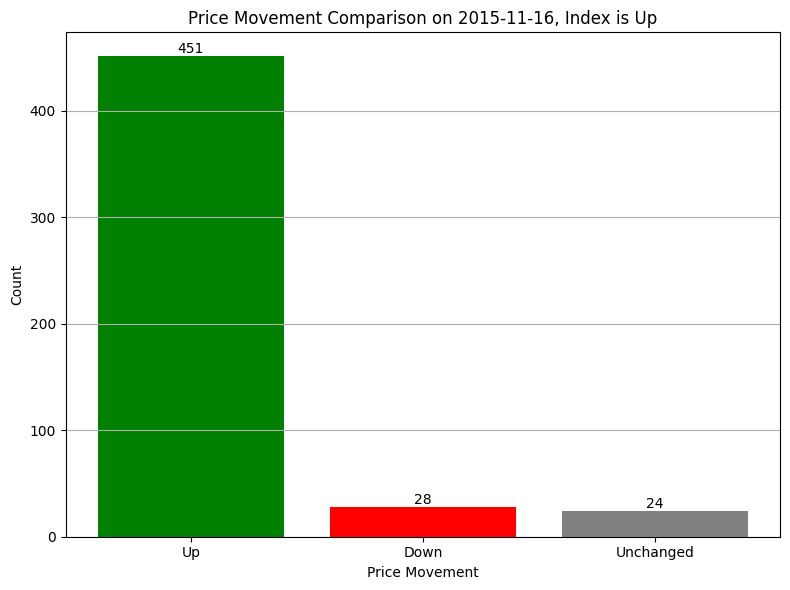

In [ ]:
def plot_price_movement_comparison(companies, index, date):
    price_movements = [company.price_movement(date) for company in companies]

    company_movement_counts = {'Up': 0, 'Down': 0, 'Unchanged': 0}
    for movement in price_movements:
        if movement == 'Up':
            company_movement_counts['Up'] += 1
        elif movement == 'Down':
            company_movement_counts['Down'] += 1
        else:
            company_movement_counts['Unchanged'] += 1

    index_movement = index.calculate_price_movement(date)

    plt.figure(figsize=(8, 6))
    bars = plt.bar(company_movement_counts.keys(), company_movement_counts.values(), color=['green', 'red', 'grey'], label="Companies")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom', ha='center')

    plt.title(f"Price Movement Comparison on {date}, Index is {index_movement}")
    plt.xlabel("Price Movement")
    plt.ylabel("Count")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_price_movement_comparison(companies, sp500, '2015-11-16')

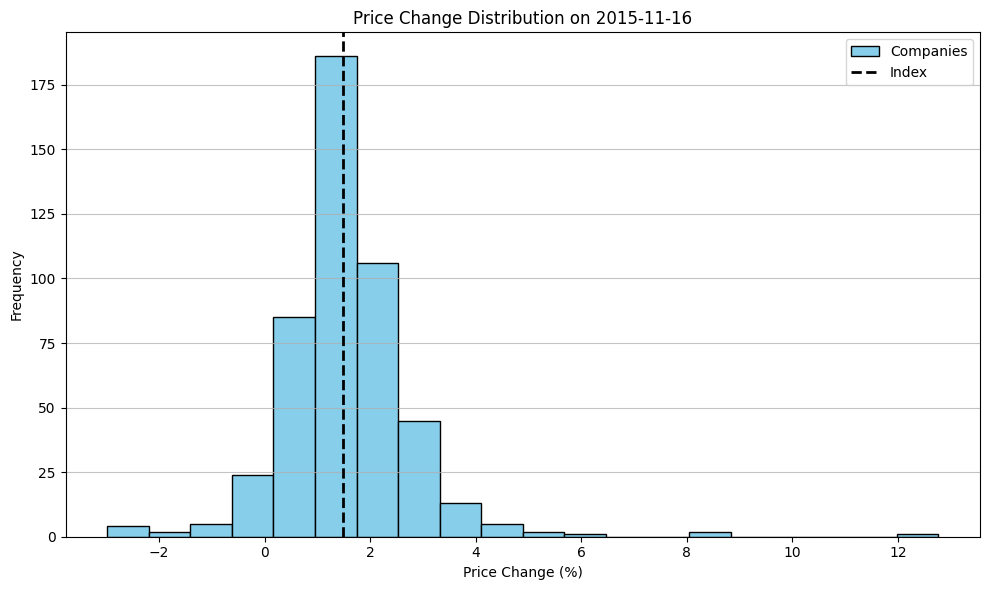

In [ ]:
def plot_price_change_distribution(companies, index, date):

    price_changes = [company.price_change(date)[1] for company in companies if company.price_change(date)[1] is not None]

    index_price_change = index.calculate_price_change(date)[1]

    plt.figure(figsize=(10, 6))

    plt.hist(price_changes, bins=20, color='skyblue', edgecolor='black', label='Companies')

    plt.axvline(x=index_price_change, color='black', linestyle='--', linewidth=2, label='Index')

    plt.title(f"Price Change Distribution on {date}")
    plt.xlabel("Price Change (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

plot_price_change_distribution(companies, sp500, '2015-11-16')

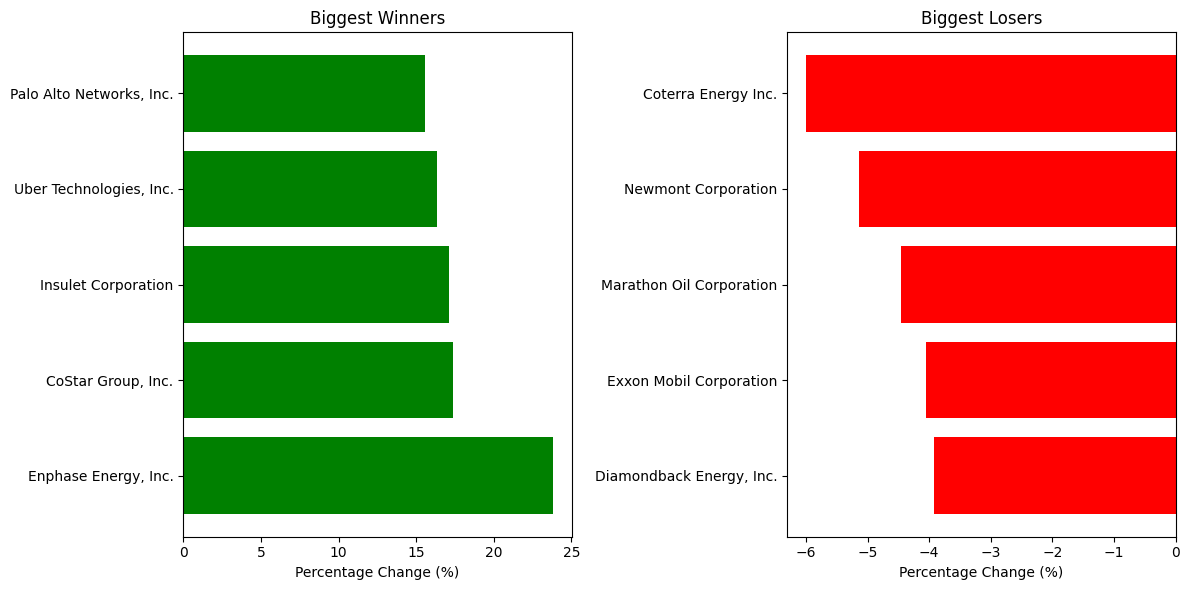

In [ ]:
def visualize_biggest_winners_and_losers(companies, date):
    company_changes = [(company, company.price_change(date)[1]) for company in companies if company.price_change(date)[1] is not None]

    sorted_companies = sorted(company_changes, key=lambda x: x[1], reverse=True)

    top_winners = sorted_companies[:5]
    top_losers = sorted_companies[-5:]

    labels_winners = [company.shortname for company, _ in top_winners]
    values_winners = [change for _, change in top_winners]

    labels_losers = [company.shortname for company, _ in top_losers]
    values_losers = [change for _, change in top_losers]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(labels_winners, values_winners, color='green')
    plt.xlabel('Percentage Change (%)')
    plt.title('Biggest Winners')

    plt.subplot(1, 2, 2)
    plt.barh(labels_losers, values_losers, color='red')
    plt.xlabel('Percentage Change (%)')
    plt.title('Biggest Losers')

    plt.tight_layout()
    plt.show()


visualize_biggest_winners_and_losers(companies, '2022-02-24')

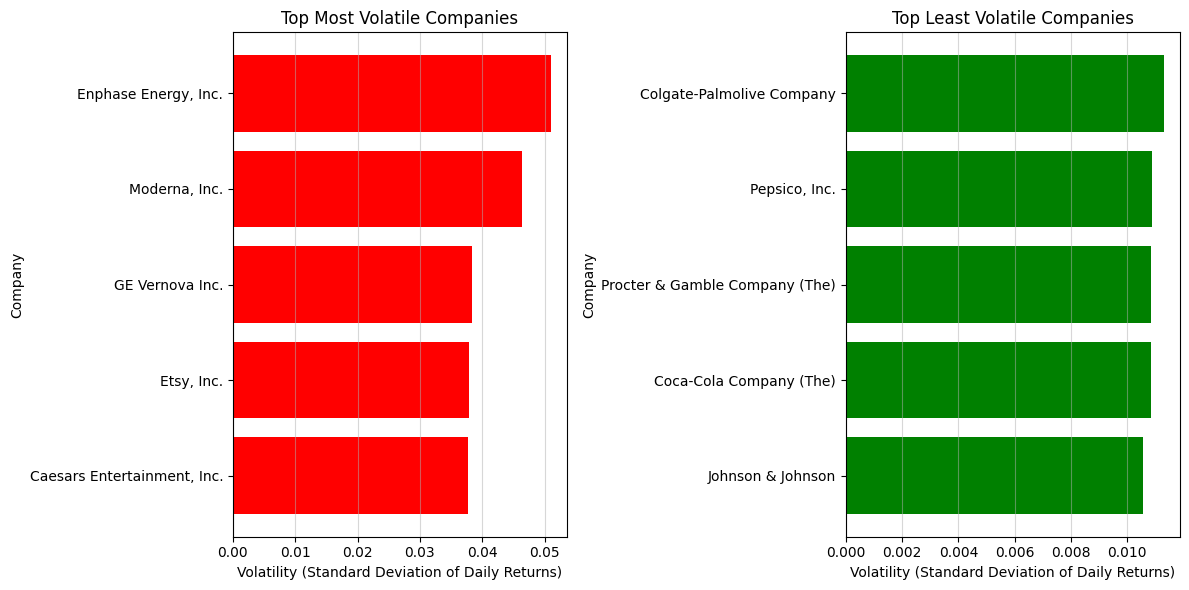

In [ ]:
def plot_volatility_comparison(companies):
    volatility = []
    for company in companies:
        stock_data = list(company.stock_data.values())
        close_prices = [data['close'] for data in stock_data]
        daily_returns = [(close_prices[i] - close_prices[i-1]) / close_prices[i-1] for i in range(1, len(close_prices))]
        volatility.append(np.std(daily_returns))

    sorted_companies = sorted(zip(companies, volatility), key=lambda x: x[1])

    top_volatile = sorted_companies[-5:]
    least_volatile = sorted_companies[:5]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh([company.shortname for company, _ in top_volatile], [vol for _, vol in top_volatile], color='red')
    plt.title("Top Most Volatile Companies")
    plt.xlabel("Volatility (Standard Deviation of Daily Returns)")
    plt.ylabel("Company")
    plt.grid(axis='x', alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.barh([company.shortname for company, _ in least_volatile], [vol for _, vol in least_volatile], color='green')
    plt.title("Top Least Volatile Companies")
    plt.xlabel("Volatility (Standard Deviation of Daily Returns)")
    plt.ylabel("Company")
    plt.grid(axis='x', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_volatility_comparison(companies)

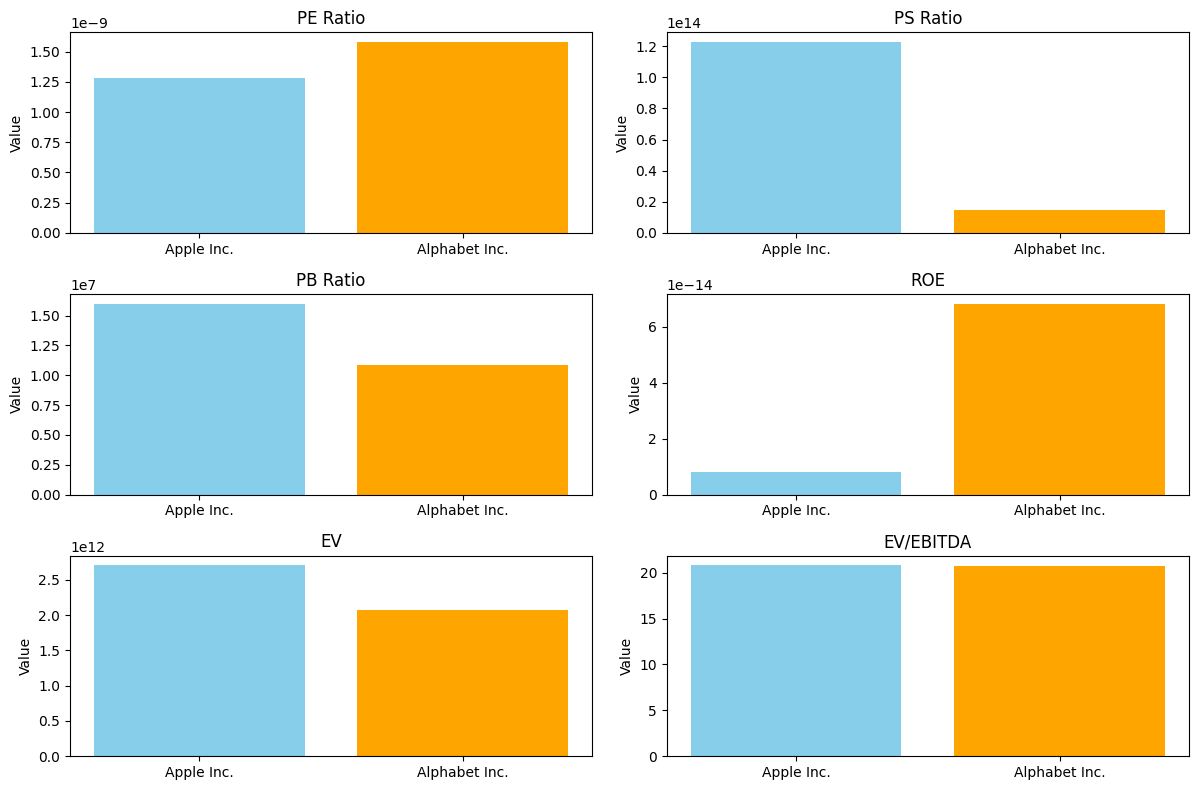

In [ ]:
def compare_metrics_by_symbol(symbol1, symbol2, companies):
    company1 = next((c for c in companies if c.symbol == symbol1), None)
    company2 = next((c for c in companies if c.symbol == symbol2), None)

    if company1 is None or company2 is None:
        print("One or both of the provided symbols is not found in the company data.")
        return

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))

    metrics = ['PE Ratio', 'PS Ratio', 'PB Ratio', 'ROE', 'EV', 'EV/EBITDA']
    company1_metrics = [company1.pe_ratio, company1.ps_ratio, company1.pb_ratio, company1.roe, company1.ev, company1.ev_ebitda_ratio]
    company2_metrics = [company2.pe_ratio, company2.ps_ratio, company2.pb_ratio, company2.roe, company2.ev, company2.ev_ebitda_ratio]

    for i, ax in enumerate(axs.flat):
        ax.bar([company1.shortname, company2.shortname], [company1_metrics[i], company2_metrics[i]], color=['skyblue', 'orange'])
        ax.set_title(metrics[i])
        ax.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

compare_metrics_by_symbol('AAPL', 'GOOGL', companies)

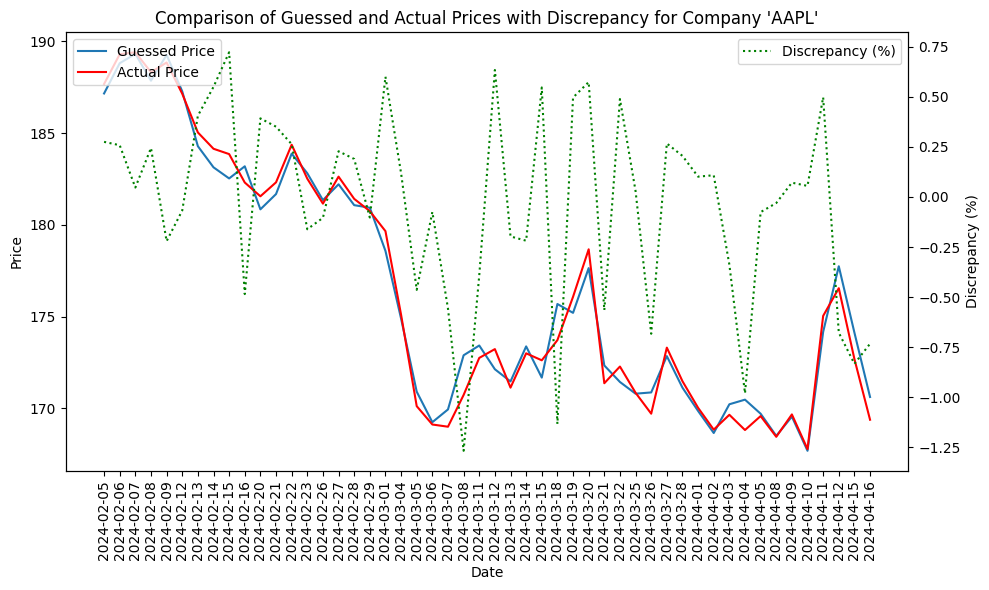

In [8]:
def compare_and_visualize(symbol, start_date, end_date):
    guessed_prices = []
    actual_prices = []
    discrepancies = []
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    while current_date <= end_date:
        date = current_date.strftime("%Y-%m-%d")
        for company in companies:
            if company.symbol == symbol:
                try:
                    guessed_price = company.ML_guess_stock_next_day(date)
                    if guessed_price is not None:
                        guessed_prices.append((date, guessed_price))
                        actual_price = company.stock_data[date]['close']
                        actual_prices.append((date, actual_price))
                        discrepancy = ((actual_price - guessed_price) / actual_price) * 100
                        discrepancies.append((date, discrepancy))
                except KeyError:
                    print(f"The selected date '{date}' is not a trading day.")

        current_date += timedelta(days=1)

    if not guessed_prices:
        print(f"No data available for symbol '{symbol}' in the specified date range.")
        return

    dates = [item[0] for item in guessed_prices]
    guessed_price_values = [item[1] for item in guessed_prices]
    actual_price_values = [item[1] for item in actual_prices]
    discrepancy_values = [item[1] for item in discrepancies]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(dates, guessed_price_values, label='Guessed Price')
    ax1.plot(dates, actual_price_values, color='red', label='Actual Price')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(dates, discrepancy_values, linestyle=':', color='green', label='Discrepancy (%)')
    ax2.set_ylabel("Discrepancy (%)")
    ax2.legend(loc='upper right')

    plt.title(f"Comparison of Guessed and Actual Prices with Discrepancy for Company '{symbol}'")
    plt.tight_layout()
    plt.show()

compare_and_visualize('AAPL', '2024-02-04', '2024-04-16')
